<a href="https://colab.research.google.com/github/ramachandra742/Machine-Learning-Projects-Jupyter/blob/master/Major_League_Baseball_logs_%26_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Major League Baseball logs & Stats**

In [0]:
import pandas as pd

Upload dataset from local drive

In [2]:
from google.colab import files
uploaded=files.upload()

Saving game_logs.csv to game_logs.csv


Load the dataset in Pandas dataframe

In [5]:
import io
df=pd.read_csv(io.BytesIO(uploaded['game_logs.csv']));

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12,13,14,15,19,20,81,83,85,87,93,94,95,96,97,98,99,100,105,106,108,109,111,112,114,115,117,118,120,121,123,124,126,127,129,130,132,133,135,136,138,139,141,142,144,145,147,148,150,151,153,154,156,157,160) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df.head()

,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,h_score,length_outs,day_night,completion,forefeit,protest,park_id,attendance,length_minutes,v_line_score,h_line_score,v_at_bats,v_hits,v_doubles,v_triples,v_homeruns,v_rbi,v_sacrifice_hits,v_sacrifice_flies,v_hit_by_pitch,v_walks,v_intentional walks,v_strikeouts,v_stolen_bases,v_caught_stealing,v_grounded_into_double,v_first_catcher_interference,v_left_on_base,v_pitchers_used,v_individual_earned_runs,...,v_player_6_name,v_player_6_def_pos,v_player_7_id,v_player_7_name,v_player_7_def_pos,v_player_8_id,v_player_8_name,v_player_8_def_pos,v_player_9_id,v_player_9_name,v_player_9_def_pos,h_player_1_id,h_player_1_name,h_player_1_def_pos,h_player_2_id,h_player_2_name,h_player_2_def_pos,h_player_3_id,h_player_3_name,h_player_3_def_pos,h_player_4_id,h_player_4_name,h_player_4_def_pos,h_player_5_id,h_player_5_name,h_player_5_def_pos,h_player_6_id,h_player_6_name,h_player_6_def_pos,h_player_7_id,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,18710504,0,Thu,CL1,na,1,FW1,na,1,0,2,54.0,D,NaN,NaN,NaN,FOR01,200.0,120.0,000000000,010010000,30.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,6.0,1.0,-1.0,-1.0,-1.0,4.0,1.0,1.0,...,Al Pratt,1.0,sutte101,Ezra Sutton,5.0,carlj102,Jim Carleton,3.0,bassj101,John Bass,6.0,selmf101,Frank Sellman,5.0,mathb101,Bobby Mathews,1.0,foraj101,Jim Foran,3.0,goldw101,Wally Goldsmith,6.0,lennb101,Bill Lennon,2.0,caret101,Tom Carey,4.0,mince101,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,18710505,0,Fri,BS1,na,1,WS3,na,1,20,18,54.0,D,NaN,NaN,NaN,WAS01,5000.0,145.0,107000435,640113030,41.0,13.0,1.0,2.0,0.0,13.0,0.0,0.0,0.0,18.0,-1.0,5.0,3.0,-1.0,-1.0,-1.0,12.0,1.0,6.0,...,Charlie Gould,3.0,schah101,Harry Schafer,5.0,conef101,Fred Cone,7.0,spala101,Al Spalding,1.0,watef102,Fred Waterman,5.0,forcd101,Davy Force,6.0,mille105,Everett Mills,3.0,allid101,Doug Allison,2.0,hallg101,George Hall,7.0,leona101,Andy Leonard,4.0,braia102,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,18710506,0,Sat,CL1,na,2,RC1,na,1,12,4,54.0,D,NaN,NaN,NaN,RCK01,1000.0,140.0,610020003,010020100,49.0,11.0,1.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,10.0,1.0,0.0,...,Al Pratt,1.0,sutte101,Ezra Sutton,5.0,carlj102,Jim Carleton,3.0,bassj101,John Bass,6.0,mackd101,Denny Mack,3.0,addyb101,Bob Addy,4.0,fishc102,Cherokee Fisher,1.0,hasts101,Scott Hastings,8.0,ham-r101,Ralph Ham,5.0,ansoc101,Cap Anson,2.0,sagep101,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,18710508,0,Mon,CL1,na,3,CH1,na,1,12,14,54.0,D,NaN,NaN,NaN,CHI01,5000.0,150.0,101403111,077000000,46.0,15.0,2.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,7.0,1.0,6.0,...,Al Pratt,1.0,sutte101,Ezra Sutton,5.0,carlj102,Jim Carleton,3.0,bassj101,John Bass,6.0,mcatb101,Bub McAtee,3.0,kingm101,Marshall King,8.0,hodec101,Charlie Hodes,2.0,woodj106,Jimmy Wood,4.0,simmj101,Joe Simmons,9.0,folet101,Tom Foley,7.0,duffe101,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,18710509,0,Tue,BS1,na,2,TRO,na,1,9,5,54.0,D,NaN,NaN,NaN,TRO01,3250.0,145.0,000002232,101003000,46.0,17.0,4.0,1.0,0.0,6.0,0.0,0.0,0.0,2.0,-1.0,0.0,1.0,-1.0,-1.0,-1.0,12.0,1.0,2.0,...,Charlie Gould,3.0,schah101,Harry Schafer,5.0,conef101,Fred Cone,7.0,spala101,Al Spalding,1.0,flync101,Clipper Flynn,9.0,mcgem101,Mike McGeary,2.0,yorkt101,Tom York,8.0,mcmuj101,John McMullin,1.0,kings101,Steve King,7.0,beave101,Edward Beavens,4.0,bells101,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


**Summary of the columns**:-  
date- Date of the game     
v_name- Visiting team name   
v_league-Visitng team league    
h_name - Home team name    
h_league- Home team league   
h_game_number- Home team game number   
v_score - Visiting team score   
h_score - Home team score   
pard_id - Id of the the park where game was held    
v_line_score - Visiting team line score   
h_line_score - Home team line score

In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171907 entries, 0 to 171906
Columns: 161 entries, date to acquisition_info
dtypes: float64(77), int64(6), object(78)
memory usage: 861.6 MB


Let's start looking at the average memory usage for each data type

In [10]:
for dtype in ['int','float','object']:
  selected_dtype=df.select_dtypes(include=[dtype])
  mem_usage_b=selected_dtype.memory_usage(deep=True).mean()
  mem_usage_mb=mem_usage_b/1024**2
  print('Average memory usage for {} columns : {:03.2f} MB'.format(dtype,mem_usage_mb))

Average memory usage for int columns : 1.12 MB
Average memory usage for float columns : 1.29 MB
Average memory usage for object columns : 9.53 MB


We can see that most of the memory used by 77 object columns

Let's look at minimum & maximum value for each integer data subtype

In [11]:
import numpy as np
int_types=['uint8','int8','int32','uint32']
for i in int_types:
  print(np.iinfo(i))

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int32
---------------------------------------------------------------
min = -2147483648
max = 2147483647
---------------------------------------------------------------

Machine parameters for uint32
---------------------------------------------------------------
min = 0
max = 4294967295
---------------------------------------------------------------



**Optimizing numerical columns with subtypes**

In [18]:
# Create a function to calcute memory usage in MB
def mem_usage(pandas_obj):
  if isinstance(pandas_obj,pd.DataFrame):
    usage_b=pandas_obj.memory_usage(deep='True').sum()
  else: # Assuming Pandas series not dataframe
    usage_b=pandas_obj.memory_usage(deep='True')
  usage_mb=usage_b/1024**2
  return '{:03.2f} MB'.format(usage_mb)
df_int=df.select_dtypes(include=['int'])
converted_int=df_int.apply(pd.to_numeric,downcast='unsigned')
print(mem_usage(df_int))
print(mem_usage(converted_int))
converted_df=pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
converted_df.columns=['before','after']
converted_df.apply(pd.Series.value_counts)

7.87 MB
1.48 MB


,before,after
uint8,NaN,5.0
uint32,NaN,1.0
int64,6.0,NaN


In [20]:
#Let's do the same thing with float columns
df_float=df.select_dtypes(include=['float'])
converted_float=df_float.apply(pd.to_numeric,downcast='float')
print(mem_usage(df_float))
print(mem_usage(converted_float))
compare_floats=pd.concat([df_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns=['before','after']
compare_floats.apply(pd.Series.value_counts)

100.99 MB
50.49 MB


,before,after
float32,NaN,77.0
float64,77.0,NaN


That is 50% reduction in memory usage for float columns

In [30]:
#Total reduction in memory usage due to int & float optimization
optimized_df=df.copy()
optimized_df[converted_int.columns]=converted_int
optimized_df[converted_float.columns]=converted_float
df_mem=mem_usage(df)
optdf_mem=mem_usage(optimized_df)
print('Memory usage for original dataframe:{}'.format(df_mem))
print('Memory usage for optimized dataframe:{}'.format(optdf_mem))

Memory usage for original dataframe:861.57 MB
Memory usage for optimized dataframe:804.69 MB


That is 6.6% reduction in memory usage for int & float columns after optimization

**Optimizing object types using categoricals**

In [38]:
df_obj=df.select_dtypes(include=['object']).copy()
df_obj.describe()

,day_of_week,v_name,v_league,h_name,h_league,day_night,completion,forefeit,protest,park_id,v_line_score,h_line_score,hp_umpire_id,hp_umpire_name,1b_umpire_id,1b_umpire_name,2b_umpire_id,2b_umpire_name,3b_umpire_id,3b_umpire_name,lf_umpire_id,lf_umpire_name,rf_umpire_id,rf_umpire_name,v_manager_id,v_manager_name,h_manager_id,h_manager_name,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,winning_rbi_batter_id,winning_rbi_batter_id_name,v_starting_pitcher_id,v_starting_pitcher_name,h_starting_pitcher_id,h_starting_pitcher_name,v_player_1_id,v_player_1_name,v_player_2_id,v_player_2_name,v_player_3_id,v_player_3_name,v_player_4_id,v_player_4_name,v_player_5_id,v_player_5_name,v_player_6_id,v_player_6_name,v_player_7_id,v_player_7_name,v_player_8_id,v_player_8_name,v_player_9_id,v_player_9_name,h_player_1_id,h_player_1_name,h_player_2_id,h_player_2_name,h_player_3_id,h_player_3_name,h_player_4_id,h_player_4_name,h_player_5_id,h_player_5_name,h_player_6_id,h_player_6_name,h_player_7_id,h_player_7_name,h_player_8_id,h_player_8_name,h_player_9_id,h_player_9_name,additional_info,acquisition_info
count,171907,171907,171907,171907,171907,140150,116,145,180,171907,147271,147271,171888,171891,147040,171891,88540,171127,116723,171135,203,171902,9,171902,171907,171907,171907,171907,140229,140229,140229,140229,48018,140838,105699,140838,171863,171863,171863,171863,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140835,140835,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,1456,140841
unique,7,148,7,148,7,2,116,3,5,245,36367,37859,1149,1146,678,678,324,325,362,363,31,32,8,9,648,648,659,659,5123,5084,5653,5606,3133,3117,5739,5674,5193,5129,5170,5125,2870,2847,3709,3673,2989,2964,2581,2563,3757,3722,4794,4736,5301,5241,4812,4763,5643,5585,2802,2782,3648,3614,2881,2858,2533,2517,3696,3660,4774,4720,5253,5197,4760,4710,5193,5142,332,1
top,Sat,CHN,NL,CHN,NL,D,"19580729,,4,3,45",H,V,STL07,000000000,000000000,klemb901,Bill Klem,connt901,(none),westj901,(none),mcgob901,(none),sudoe901,(none),gormt101,(none),mackc101,Connie Mack,mackc101,Connie Mack,johnw102,Walter Johnson,rixee101,Dutch Leonard,rivem002,(none),pujoa001,(none),younc102,Young,younc102,Young,suzui001,Ichiro Suzuki,fox-n101,Nellie Fox,speat101,Tris Speaker,bottj101,Jim Bottomley,heilh101,Harry Heilmann,grimc101,Charlie Grimm,grimc101,Charlie Grimm,lopea102,Al Lopez,grifa001,Alfredo Griffin,suzui001,Ichiro Suzuki,fox-n101,Nellie Fox,speat101,Tris Speaker,gehrl101,Lou Gehrig,heilh101,Harry Heilmann,grimc101,Charlie Grimm,grimc101,Charlie Grimm,lopea102,Al Lopez,spahw101,Warren Spahn,HTBF,Y
freq,28891,8870,88866,9024,88867,82724,1,69,90,7022,10102,8028,3545,3545,2029,24851,815,82587,1129,54412,30,171699,2,171893,3901,3901,3848,3848,385,385,251,295,523,92820,288,35139,403,441,412,451,893,893,852,852,1224,1224,816,816,663,663,465,465,485,485,687,687,333,333,927,927,859,859,1165,1165,752,752,612,612,427,427,491,491,676,676,339,339,1112,140841


In [39]:
#loop to iterate over each object column, to check if number of unique values is less than 50% & if so, convert it to category type
converted_obj=pd.DataFrame()
for col in df_obj.columns:
  numb_unique_values=len(df_obj[col].unique())
  numb_total_values=len(df_obj[col])
  if numb_unique_values/numb_total_values<0.5:
    converted_obj.loc[:,col]=df_obj[col].astype('category')
  else:
    converted_obj.loc[:,col]=df_obj[col]
print(mem_usage(df_obj))
print(mem_usage(converted_obj))
compare_df=pd.concat([df_obj.dtypes,converted_obj.dtypes],axis=1)
compare_df.columns=['before','after']
compare_df.apply(pd.Series.value_counts)

752.72 MB
51.67 MB


,before,after
object,78.0,NaN
category,NaN,2.0
category,NaN,1.0
category,NaN,1.0
category,NaN,1.0
category,NaN,1.0
category,NaN,1.0
category,NaN,1.0
category,NaN,1.0
category,NaN,1.0


In [40]:
optimized_df[converted_obj.columns]=converted_obj
print(mem_usage(df))
print(mem_usage(optimized_df))

861.57 MB
103.64 MB


In [42]:
#date time column optimization
date=optimized_df.date
print(mem_usage(date))
date.head()

0.66 MB


0    18710504
1    18710505
2    18710506
3    18710508
4    18710509
Name: date, dtype: uint32

In [44]:
# Change date formate to year-month-day
optimized_df['date']=pd.to_datetime(date,format='%Y%m%d')
print(mem_usage(optimized_df))
optimized_df.date.head()

104.29 MB


0   1871-05-04
1   1871-05-05
2   1871-05-06
3   1871-05-08
4   1871-05-09
Name: date, dtype: datetime64[ns]

That is overall 87.9% reduction in memory usage after optimization

Analyzing Baseball games

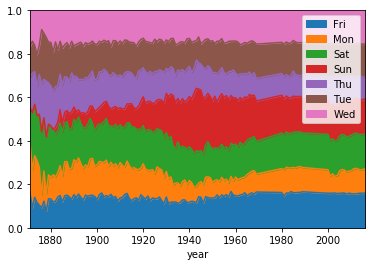

In [47]:
#Let's start by looking at the distribution of game days
import matplotlib.pyplot as plt
optimized_df['year']=optimized_df.date.dt.year
games_per_day=optimized_df.pivot_table(index='year',columns='day_of_week',values='date',aggfunc=len)
games_per_day=games_per_day.divide(games_per_day.sum(axis=1),axis=0)
ax=games_per_day.plot(kind='area',stacked='true')
ax.legend(loc='upper right')
ax.set_ylim(0,1)
plt.show()

Let's look at how game length has varied over years

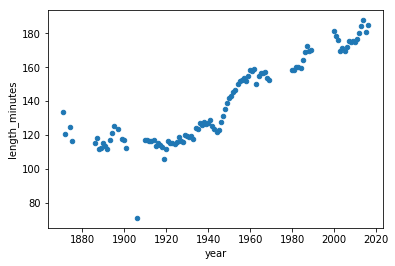

In [48]:
game_lengths=optimized_df.pivot_table(index='year',values='length_minutes')
game_lengths.reset_index().plot.scatter('year','length_minutes')
plt.show()